# Tuning
In this notebook we find the best combination of columns to use in the product matching task.
## Requirements

In [ ]:
!pip install -r requirements.txt && python -m laserembeddings download-models

## Imports and test method

In [2]:
from laserembeddings import Laser
from annoy import AnnoyIndex
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def build_and_test(df, col_name, test_series, top=[1,5]):
    emb = Laser().embed_sentences(df[col_name], lang='pl')
    annoy_idx = AnnoyIndex(emb.shape[1], "angular")
    for idx, vec in enumerate(emb):
        annoy_idx.add_item(idx, vec)
    annoy_idx.build(10)       
    count = {t: 0 for t in top}
    for idx, ean in test_series.items():
        for num in count.keys():
            nn_ean = map(
                lambda i: df.EAN[i],
                filter(
                    lambda i: i != idx,
                    annoy_idx.get_nns_by_item(idx, num + 1)
                )
            )
            if ean in nn_ean:
                count[num] += 1          
    full_count = len(test_series)
    res = {key: value / full_count for key, value in count.items()}
    print(f"{col_name} - {res}")
    return res

In [3]:
def gen_test_series(df):
    eans = df.groupby("EAN").count().query(f"{df.columns[1]} > 1").index.unique()
    return df[df["EAN"].isin(eans)]["EAN"]

## Data load and preprocessing

In [4]:
df = pd.read_csv("sampleData.csv", index_col=0)

df.EAN = df.EAN.str.lstrip()

df.price = df.price.str.replace(
    r"(?P<zl>\d+)[.,](?P<gr>\d+)", 
    lambda m: f"{m.group('zl')},{m.group('gr')} zł", 
    regex=True
)

df.head()

EAN amount         brand capacity  \
0  5900541000031    9 l  ŻYWIEC ZDRÓJ      9 l   
1  5900334012685    1 l       TYMBARK      1 l   
2  5900334120755   12 l       TYMBARK     12 l   
3  5900334012753    1 l       TYMBARK      1 l   
4  5900334120748   12 l       TYMBARK     12 l   

                                            category  \
0  Napoje > Woda > Niegazowana > ŻYWIEC ZDRÓJ Nie...   
1  Napoje > Soki i nektary > Soki owocowe > Pomar...   
2  Napoje > Soki i nektary > Soki owocowe > Pomar...   
3  Napoje > Soki i nektary > Soki owocowe > Jabłk...   
4  Napoje > Soki i nektary > Soki owocowe > Jabłk...   

                                         description extras  \
0  Idealnie zrównoważona woda źródlana, pochodząc...    NaN   
1  TYMBARK Sok 100% Pomarańcza\n\nSok pomarańczow...    NaN   
2  TYMBARK Sok 100% Pomarańcza\n\nSok pomarańczow...    NaN   
3  TYMBARK Sok 100% Jabłko\n\nWyśmienity, zdrowy ...    NaN   
4  TYMBARK Sok 100% Jabłko\n\nWyśmienity, zdrowy ...    NaN   

                                           image_url ingredients origin  \
0  https://www.frisco.pl/pid,723/n,zywiec-zdroj-n...         NaN    NaN   
1  https://www.frisco.pl/pid,322/n,tymbark-sok-10...         NaN    NaN   
2          https://www.frisco.pl/pid,323/stn,product         NaN    NaN   
3  https://www.frisco.pl/pid,320/n,tymbark-sok-10...         NaN    NaN   
4          https://www.frisco.pl/pid,321/stn,product         NaN    NaN   

      price  seller                                            storage  \
0  11,94 zł  Frisco  Przechowywać w chłodnym i zaciemnionym miejscu...   
1   3,99 zł  Frisco                                                NaN   
2  47,88 zł  Frisco                                                NaN   
3   3,59 zł  Frisco                                                NaN   
4  43,08 zł  Frisco                                                NaN   

                         title  \
0     ŻYWIEC ZDRÓJ Niegazowany   
1  TYMBARK Sok 100% Pomarańcza   
2  TYMBARK Sok 100% Pomarańcza   
3      TYMBARK Sok 100% Jabłko   
4      TYMBARK Sok 100% Jabłko   

                                                 url            weight  
0  https://www.frisco.pl/pid,723/n,zywiec-zdroj-n...  Waga brutto 1533  
1  https://www.frisco.pl/pid,322/n,tymbark-sok-10...               NaN  
2          https://www.frisco.pl/pid,323/stn,product               NaN  
3  https://www.frisco.pl/pid,320/n,tymbark-sok-10...               NaN  
4          https://www.frisco.pl/pid,321/stn,product               NaN

In [5]:
test = gen_test_series(df)

Test only <i>title</i> column

In [6]:
build_and_test(df, "title", test)

title - {1: 0.7198375870069605, 5: 0.8799303944315545}


{1: 0.7198375870069605, 5: 0.8799303944315545}

## Testing column combinations

In [7]:
import itertools

columns = {
    'amount': 'ilość', 
    'brand': 'marka', 
    'capacity': 'pojemność', 
    'category': 'kategoria', 
    'price': 'cena',
    'title': '',
}

subsets = itertools.chain.from_iterable([
    itertools.combinations(columns, r)
    for r in range(1, len(columns) + 1)
])

df_ext = df.loc[:, list(columns.keys()) + ["EAN"]]
for subset in subsets:
    if len(subset) > 1:
        df_ext.loc[:, "_".join(subset)] = df.apply(
            lambda r: " i ".join([f"{columns[key]} {r[key]}" for key in subset]),
            axis=1
        )

df_ext.head()

amount         brand capacity  \
0    9 l  ŻYWIEC ZDRÓJ      9 l   
1    1 l       TYMBARK      1 l   
2   12 l       TYMBARK     12 l   
3    1 l       TYMBARK      1 l   
4   12 l       TYMBARK     12 l   

                                            category     price  \
0  Napoje > Woda > Niegazowana > ŻYWIEC ZDRÓJ Nie...  11,94 zł   
1  Napoje > Soki i nektary > Soki owocowe > Pomar...   3,99 zł   
2  Napoje > Soki i nektary > Soki owocowe > Pomar...  47,88 zł   
3  Napoje > Soki i nektary > Soki owocowe > Jabłk...   3,59 zł   
4  Napoje > Soki i nektary > Soki owocowe > Jabłk...  43,08 zł   

                         title            EAN                    amount_brand  \
0     ŻYWIEC ZDRÓJ Niegazowany  5900541000031  ilość 9 l i marka ŻYWIEC ZDRÓJ   
1  TYMBARK Sok 100% Pomarańcza  5900334012685       ilość 1 l i marka TYMBARK   
2  TYMBARK Sok 100% Pomarańcza  5900334120755      ilość 12 l i marka TYMBARK   
3      TYMBARK Sok 100% Jabłko  5900334012753       ilość 1 l i marka TYMBARK   
4      TYMBARK Sok 100% Jabłko  5900334120748      ilość 12 l i marka TYMBARK   

               amount_capacity  \
0    ilość 9 l i pojemność 9 l   
1    ilość 1 l i pojemność 1 l   
2  ilość 12 l i pojemność 12 l   
3    ilość 1 l i pojemność 1 l   
4  ilość 12 l i pojemność 12 l   

                                     amount_category  ...  \
0  ilość 9 l i kategoria Napoje > Woda > Niegazow...  ...   
1  ilość 1 l i kategoria Napoje > Soki i nektary ...  ...   
2  ilość 12 l i kategoria Napoje > Soki i nektary...  ...   
3  ilość 1 l i kategoria Napoje > Soki i nektary ...  ...   
4  ilość 12 l i kategoria Napoje > Soki i nektary...  ...   

                          brand_capacity_price_title  \
0  marka ŻYWIEC ZDRÓJ i pojemność 9 l i cena 11,9...   
1  marka TYMBARK i pojemność 1 l i cena 3,99 zł i...   
2  marka TYMBARK i pojemność 12 l i cena 47,88 zł...   
3  marka TYMBARK i pojemność 1 l i cena 3,59 zł i...   
4  marka TYMBARK i pojemność 12 l i cena 43,08 zł...   

                          brand_category_price_title  \
0  marka ŻYWIEC ZDRÓJ i kategoria Napoje > Woda >...   
1  marka TYMBARK i kategoria Napoje > Soki i nekt...   
2  marka TYMBARK i kategoria Napoje > Soki i nekt...   
3  marka TYMBARK i kategoria Napoje > Soki i nekt...   
4  marka TYMBARK i kategoria Napoje > Soki i nekt...   

                       capacity_category_price_title  \
0  pojemność 9 l i kategoria Napoje > Woda > Nieg...   
1  pojemność 1 l i kategoria Napoje > Soki i nekt...   
2  pojemność 12 l i kategoria Napoje > Soki i nek...   
3  pojemność 1 l i kategoria Napoje > Soki i nekt...   
4  pojemność 12 l i kategoria Napoje > Soki i nek...   

                amount_brand_capacity_category_price  \
0  ilość 9 l i marka ŻYWIEC ZDRÓJ i pojemność 9 l...   
1  ilość 1 l i marka TYMBARK i pojemność 1 l i ka...   
2  ilość 12 l i marka TYMBARK i pojemność 12 l i ...   
3  ilość 1 l i marka TYMBARK i pojemność 1 l i ka...   
4  ilość 12 l i marka TYMBARK i pojemność 12 l i ...   

                amount_brand_capacity_category_title  \
0  ilość 9 l i marka ŻYWIEC ZDRÓJ i pojemność 9 l...   
1  ilość 1 l i marka TYMBARK i pojemność 1 l i ka...   
2  ilość 12 l i marka TYMBARK i pojemność 12 l i ...   
3  ilość 1 l i marka TYMBARK i pojemność 1 l i ka...   
4  ilość 12 l i marka TYMBARK i pojemność 12 l i ...   

                   amount_brand_capacity_price_title  \
0  ilość 9 l i marka ŻYWIEC ZDRÓJ i pojemność 9 l...   
1  ilość 1 l i marka TYMBARK i pojemność 1 l i ce...   
2  ilość 12 l i marka TYMBARK i pojemność 12 l i ...   
3  ilość 1 l i marka TYMBARK i pojemność 1 l i ce...   
4  ilość 12 l i marka TYMBARK i pojemność 12 l i ...   

                   amount_brand_category_price_title  \
0  ilość 9 l i marka ŻYWIEC ZDRÓJ i kategoria Nap...   
1  ilość 1 l i marka TYMBARK i kategoria Napoje >...   
2  ilość 12 l i marka TYMBARK i kategoria Napoje ...   
3  ilość 1 l i marka TYMBARK i kategoria Napoje >...   
4  ilość 12 l i marka TYMBARK i k

In [8]:
results = {
    col: build_and_test(df_ext, col, test)
    for col in tqdm(df_ext.columns)
    if col != "EAN"
}

  0%|          | 0/64 [00:00<?, ?it/s]

amount - {1: 0.07163573085846868, 5: 0.1593677494199536}
brand - {1: 0.08758700696055685, 5: 0.21476218097447797}
capacity - {1: 0.03958816705336427, 5: 0.09556264501160093}
category - {1: 0.5475638051044084, 5: 0.6899651972157773}
price - {1: 0.09585266821345707, 5: 0.2021461716937355}
title - {1: 0.7198375870069605, 5: 0.8799303944315545}
amount_brand - {1: 0.2769721577726218, 5: 0.546983758700696}
amount_capacity - {1: 0.06917053364269142, 5: 0.14617169373549885}
amount_category - {1: 0.7134570765661253, 5: 0.7175174013921114}
amount_price - {1: 0.26377610208816704, 5: 0.4955046403712297}
amount_title - {1: 0.878915313225058, 5: 0.929814385150812}
brand_capacity - {1: 0.2302784222737819, 5: 0.4691125290023202}
brand_category - {1: 0.546983758700696, 5: 0.6931554524361949}
brand_price - {1: 0.3355568445475638, 5: 0.5855568445475638}
brand_title - {1: 0.7104118329466357, 5: 0.8838457076566125}
capacity_category - {1: 0.709106728538283, 5: 0.7172273781902552}
capacity_price - {1: 0.232

## Results

### Score vs column combination

In [9]:
results_parsed = [
    {**dict(col=key), **value}
    for key, value in results.items()
]

res_df = pd.DataFrame(results_parsed).sort_values(by=[1,5], ascending=False)
res_df.head()


col         1         5
10        amount_title  0.878915  0.929814
24  amount_brand_title  0.866444  0.938225
20         price_title  0.842082  0.903567
30  amount_price_title  0.816560  0.905017
36   brand_price_title  0.809455  0.896607

In [10]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(20,10))
plt.plot(res_df.col, res_df[1])
plt.plot(res_df.col, res_df[5])
plt.xticks(res_df.col, rotation='vertical')
plt.yticks(np.r_[0:1:0.05])
plt.grid(True)
plt.legend(["top 1", "top 5"])
plt.style.use('ggplot')
plt.show()

### Top 1-5 score for best 5 combinations

In [13]:
results_ext = [
    {**{'col': col}, **build_and_test(df_ext, col, test, top=[1,2,3,4,5])}
    for col in tqdm(res_df.head(5).col.tolist() + ['title'])
]
results_ext


  0%|          | 0/6 [00:00<?, ?it/s]

amount_title - {1: 0.878915313225058, 2: 0.900377030162413, 3: 0.915893271461717, 4: 0.921983758700696, 5: 0.929814385150812}
amount_brand_title - {1: 0.8664443155452436, 2: 0.8939965197215777, 3: 0.9166183294663574, 4: 0.9305394431554525, 5: 0.9382250580046404}
price_title - {1: 0.8420823665893271, 2: 0.8713747099767981, 3: 0.8879060324825986, 4: 0.898491879350348, 5: 0.9035672853828306}
amount_price_title - {1: 0.8165603248259861, 2: 0.8552784222737819, 3: 0.8777552204176334, 4: 0.8935614849187935, 5: 0.9050174013921114}
brand_price_title - {1: 0.8094547563805105, 2: 0.8446925754060325, 3: 0.8680394431554525, 4: 0.8870359628770301, 5: 0.896606728538283}
title - {1: 0.7198375870069605, 2: 0.786977958236659, 3: 0.8519431554524362, 4: 0.8661542923433875, 5: 0.8799303944315545}


[{'col': 'amount_title',
  1: 0.878915313225058,
  2: 0.900377030162413,
  3: 0.915893271461717,
  4: 0.921983758700696,
  5: 0.929814385150812},
 {'col': 'amount_brand_title',
  1: 0.8664443155452436,
  2: 0.8939965197215777,
  3: 0.9166183294663574,
  4: 0.9305394431554525,
  5: 0.9382250580046404},
 {'col': 'price_title',
  1: 0.8420823665893271,
  2: 0.8713747099767981,
  3: 0.8879060324825986,
  4: 0.898491879350348,
  5: 0.9035672853828306},
 {'col': 'amount_price_title',
  1: 0.8165603248259861,
  2: 0.8552784222737819,
  3: 0.8777552204176334,
  4: 0.8935614849187935,
  5: 0.9050174013921114},
 {'col': 'brand_price_title',
  1: 0.8094547563805105,
  2: 0.8446925754060325,
  3: 0.8680394431554525,
  4: 0.8870359628770301,
  5: 0.896606728538283},
 {'col': 'title',
  1: 0.7198375870069605,
  2: 0.786977958236659,
  3: 0.8519431554524362,
  4: 0.8661542923433875,
  5: 0.8799303944315545}]

In [14]:
top12354_df = pd.DataFrame(results_ext).sort_values(by=list(range(1,6)), ascending=False)
plt.figure(figsize=(10,8))
for col in range(1,6):
    plt.plot(top12354_df['col'], top12354_df[col])
plt.xticks(top12354_df.col, rotation=45)
plt.grid(True)
plt.legend([f"top {i}" for i in range(1,6)])
plt.style.use('ggplot')
plt.show() 

### Column used

In [15]:
plt.figure(figsize=(12,8))
plt.bar(top12354_df['col'], top12354_df[1]* 100)
plt.ylabel('Odnalezione odpowiedniki [%]')
plt.xlabel('Kolumny uwzględnione w modelu')
plt.title("Skuteczność dopasowania najlepszej rekomendacji")
plt.ylim(70, 100)
plt.show()

In [16]:
top12354_df_t = top12354_df.transpose().reset_index()
header = top12354_df_t.iloc[0, :]
top12354_df_t = top12354_df_t.iloc[1:, :]
top12354_df_t.columns=header
top12354_df_t

0 col amount_title amount_brand_title price_title amount_price_title  \
1   1     0.878915           0.866444    0.842082           0.816560   
2   2     0.900377           0.893997    0.871375           0.855278   
3   3     0.915893           0.916618    0.887906           0.877755   
4   4     0.921984           0.930539    0.898492           0.893561   
5   5     0.929814           0.938225    0.903567           0.905017   

0 brand_price_title     title  
1          0.809455  0.719838  
2          0.844693  0.786978  
3          0.868039  0.851943  
4          0.887036  0.866154  
5          0.896607  0.879930

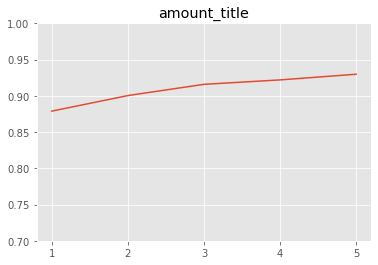

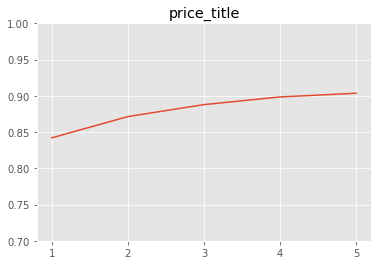

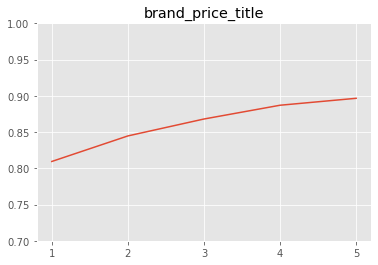

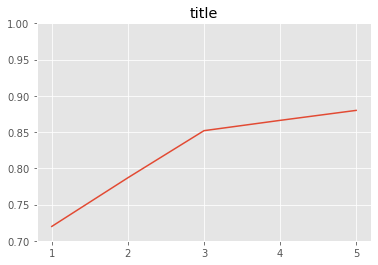

In [17]:
for col in top12354_df_t.columns:
    if col != "col":
        plt.plot(top12354_df_t.col, top12354_df_t[col])
        plt.title(col)
        plt.xticks(top12354_df_t.col.tolist())
        plt.yticks(np.r_[0.7:1:0.05])
        plt.show()

### Best combination score

In [18]:
plt.figure(figsize=(12,8))
plt.bar(top12354_df_t.col, top12354_df_t['amount_title'] * 100)
plt.title("Skuteczność rekomendacji dla najlepszego zbioru cech - amount_title")
plt.xticks(top12354_df_t.col.tolist())
plt.ylim(75,100)
plt.xlabel('Top X rekomendacji') 
plt.ylabel('Odnalezione odpowiedniki [%]')
plt.show()

### Test column permutations

In [19]:
df_perm = df.loc[:, ["EAN"]]
for col in res_df.head(5).col:
    for perm in  itertools.permutations(col.split('_')):
        df_perm.loc[:, '_'.join(perm)] = df.apply(
            lambda r: " i ".join([f"{columns[key]} {r[key]}" for key in perm]),
            axis=1
        )
df_perm.head()

EAN                               amount_title  \
0  5900541000031      ilość 9 l i  ŻYWIEC ZDRÓJ Niegazowany   
1  5900334012685   ilość 1 l i  TYMBARK Sok 100% Pomarańcza   
2  5900334120755  ilość 12 l i  TYMBARK Sok 100% Pomarańcza   
3  5900334012753       ilość 1 l i  TYMBARK Sok 100% Jabłko   
4  5900334120748      ilość 12 l i  TYMBARK Sok 100% Jabłko   

                                title_amount  \
0       ŻYWIEC ZDRÓJ Niegazowany i ilość 9 l   
1    TYMBARK Sok 100% Pomarańcza i ilość 1 l   
2   TYMBARK Sok 100% Pomarańcza i ilość 12 l   
3        TYMBARK Sok 100% Jabłko i ilość 1 l   
4       TYMBARK Sok 100% Jabłko i ilość 12 l   

                                  amount_brand_title  \
0  ilość 9 l i marka ŻYWIEC ZDRÓJ i  ŻYWIEC ZDRÓJ...   
1  ilość 1 l i marka TYMBARK i  TYMBARK Sok 100% ...   
2  ilość 12 l i marka TYMBARK i  TYMBARK Sok 100%...   
3  ilość 1 l i marka TYMBARK i  TYMBARK Sok 100% ...   
4  ilość 12 l i marka TYMBARK i  TYMBARK Sok 100%...   

                                  amount_title_brand  \
0  ilość 9 l i  ŻYWIEC ZDRÓJ Niegazowany i marka ...   
1  ilość 1 l i  TYMBARK Sok 100% Pomarańcza i mar...   
2  ilość 12 l i  TYMBARK Sok 100% Pomarańcza i ma...   
3  ilość 1 l i  TYMBARK Sok 100% Jabłko i marka T...   
4  ilość 12 l i  TYMBARK Sok 100% Jabłko i marka ...   

                                  brand_amount_title  \
0  marka ŻYWIEC ZDRÓJ i ilość 9 l i  ŻYWIEC ZDRÓJ...   
1  marka TYMBARK i ilość 1 l i  TYMBARK Sok 100% ...   
2  marka TYMBARK i ilość 12 l i  TYMBARK Sok 100%...   
3  marka TYMBARK i ilość 1 l i  TYMBARK Sok 100% ...   
4  marka TYMBARK i ilość 12 l i  TYMBARK Sok 100%...   

                                  brand_title_amount  \
0  marka ŻYWIEC ZDRÓJ i  ŻYWIEC ZDRÓJ Niegazowany...   
1  marka TYMBARK i  TYMBARK Sok 100% Pomarańcza i...   
2  marka TYMBARK i  TYMBARK Sok 100% Pomarańcza i...   
3  marka TYMBARK i  TYMBARK Sok 100% Jabłko i ilo...   
4  marka TYMBARK i  TYMBARK Sok 100% Jabłko i ilo...   

                                  title_amount_brand  \
0   ŻYWIEC ZDRÓJ Niegazowany i ilość 9 l i marka ...   
1   TYMBARK Sok 100% Pomarańcza i ilość 1 l i mar...   
2   TYMBARK Sok 100% Pomarańcza i ilość 12 l i ma...   
3   TYMBARK Sok 100% Jabłko i ilość 1 l i marka T...   
4   TYMBARK Sok 100% Jabłko i ilość 12 l i marka ...   

                                  title_brand_amount  \
0   ŻYWIEC ZDRÓJ Niegazowany i marka ŻYWIEC ZDRÓJ...   
1   TYMBARK Sok 100% Pomarańcza i marka TYMBARK i...   
2   TYMBARK Sok 100% Pomarańcza i marka TYMBARK i...   
3   TYMBARK Sok 100% Jabłko i marka TYMBARK i ilo...   
4   TYMBARK Sok 100% Jabłko i marka TYMBARK i ilo...   

                                    price_title  ...  \
0     cena 11,94 zł i  ŻYWIEC ZDRÓJ Niegazowany  ...   
1   cena 3,99 zł i  TYMBARK Sok 100% Pomarańcza  ...   
2  cena 47,88 zł i  TYMBARK Sok 100% Pomarańcza  ...   
3       cena 3,59 zł i  TYMBARK Sok 100% Jabłko  ...   
4      cena 43,08 zł i  TYMBARK Sok 100% Jabłko  ...   

                                  price_amount_title  \
0  cena 11,94 zł i ilość 9 l i  ŻYWIEC ZDRÓJ Nieg...   
1  cena 3,99 zł i ilość 1 l i  TYMBARK Sok 100% P...   
2  cena 47,88 zł i ilość 12 l i  TYMBARK Sok 100%...   
3  cena 3,59 zł i ilość 1 l i  TYMBARK Sok 100% J...   
4  cena 43,08 zł i ilość 12 l i  TYMBARK Sok 100%...   

                                  price_title_amount  \
0  cena 11,94 zł i  ŻYWIEC ZDRÓJ Niegazowany i il...   
1  cena 3,99 zł i  TYMBARK Sok 100% Pomarańcza i ...   
2  cena 47,88 zł i  TYMBARK Sok 100% Pomarańcza i...   
3  cena 3,59 zł i  TYMBARK Sok 100% Jabłko i iloś...   
4  cena 43,08 zł i  TYMBARK Sok 100% Jabłko i ilo...   

                                  title_amount_price  \
0   ŻYWIEC ZDRÓJ Niegazowany i ilość 9 l i cena 1...   
1   TYMBARK Sok 100% Pomarańcza i ilość 1 l i cen...   
2   TYMBARK Sok 100% Pomarańcza i ilość 12 l i ce...   
3   TYMBARK Sok 100% Jabłko i ilość 1 l i cena 3,...   
4   TYMBARK Sok 100% Jabłko i il

In [20]:
results_perm = [
    {**{'col': col}, **build_and_test(df_perm, col, test)}
    for col in tqdm(df_perm.columns)
    if col != "EAN"
]
results_perm

  0%|          | 0/23 [00:00<?, ?it/s]

amount_title - {1: 0.878915313225058, 5: 0.929814385150812}
title_amount - {1: 0.8829756380510441, 5: 0.9408352668213457}
amount_brand_title - {1: 0.8664443155452436, 5: 0.9382250580046404}
amount_title_brand - {1: 0.859338747099768, 5: 0.9357598607888631}
brand_amount_title - {1: 0.8696345707656613, 5: 0.947215777262181}
brand_title_amount - {1: 0.8796403712296984, 5: 0.9537412993039444}
title_amount_brand - {1: 0.8596287703016241, 5: 0.9405452436194895}
title_brand_amount - {1: 0.8602088167053364, 5: 0.9404002320185615}
price_title - {1: 0.8420823665893271, 5: 0.9035672853828306}
title_price - {1: 0.8314965197215777, 5: 0.8968967517401392}
amount_price_title - {1: 0.8165603248259861, 5: 0.9050174013921114}
amount_title_price - {1: 0.8187354988399071, 5: 0.9113979118329466}
price_amount_title - {1: 0.8200406032482599, 5: 0.9154582366589327}
price_title_amount - {1: 0.8296113689095128, 5: 0.925754060324826}
title_amount_price - {1: 0.8255510440835266, 5: 0.9151682134570766}
title_price

[{'col': 'amount_title', 1: 0.878915313225058, 5: 0.929814385150812},
 {'col': 'title_amount', 1: 0.8829756380510441, 5: 0.9408352668213457},
 {'col': 'amount_brand_title', 1: 0.8664443155452436, 5: 0.9382250580046404},
 {'col': 'amount_title_brand', 1: 0.859338747099768, 5: 0.9357598607888631},
 {'col': 'brand_amount_title', 1: 0.8696345707656613, 5: 0.947215777262181},
 {'col': 'brand_title_amount', 1: 0.8796403712296984, 5: 0.9537412993039444},
 {'col': 'title_amount_brand', 1: 0.8596287703016241, 5: 0.9405452436194895},
 {'col': 'title_brand_amount', 1: 0.8602088167053364, 5: 0.9404002320185615},
 {'col': 'price_title', 1: 0.8420823665893271, 5: 0.9035672853828306},
 {'col': 'title_price', 1: 0.8314965197215777, 5: 0.8968967517401392},
 {'col': 'amount_price_title', 1: 0.8165603248259861, 5: 0.9050174013921114},
 {'col': 'amount_title_price', 1: 0.8187354988399071, 5: 0.9113979118329466},
 {'col': 'price_amount_title', 1: 0.8200406032482599, 5: 0.9154582366589327},
 {'col': 'price_

In [21]:
results_perm_df = pd.DataFrame(results_perm).sort_values(by=[1,5], ascending=False)
results_perm_df.head()

col         1         5
1        title_amount  0.882976  0.940835
5  brand_title_amount  0.879640  0.953741
0        amount_title  0.878915  0.929814
4  brand_amount_title  0.869635  0.947216
2  amount_brand_title  0.866444  0.938225

In [22]:
f = plt.figure(figsize=(20,10))
plt.plot(results_perm_df.col, results_perm_df[1])
plt.plot(results_perm_df.col, results_perm_df[5])
plt.xticks(results_perm_df.col, rotation='vertical')
plt.grid(True)
plt.legend(["top 1", "top 5"])
plt.style.use('ggplot')
plt.show()